In [16]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json
import random
from sklearn.preprocessing import MinMaxScaler


# Task B: Damage Level Classification

Create a damage level classifier for the `hurricane-matthew` disaster.

## Feature Engineering

Which features are useful for this classification task? Construct them here.

We have around 5000 points with a label one, and we have 1500 points with a label of two. There are two ways we can work with this knowledge. First, we can built a dataset where we have the same number of datapoints for each label. Then, we can try weighing the inputs by their length to make a less-occuring label have a higher impact on the direction of the model.

1    5236
0    2631
3    1740
2 1544nt64

### DataSet1: Same Number of Datapoints per Label

In [34]:
# smallest number of images for a given label is 1544
data_dir = "satellite-image-data"
hurricane_features = pd.read_csv("hurricane_equal_labels.csv")

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.885763,16.916395,7.241595,7.523252,6.458311,1.500000
std,0.498158,1.271751,0.555298,0.525819,3.643570,1.118125
min,0.033381,9.833333,4.485958,4.716797,0.344656,0.000000
25%,0.525074,15.979694,6.881235,7.190165,4.000047,0.750000
50%,0.789928,16.922966,7.226459,7.509186,5.537527,1.500000
75%,1.144976,17.951635,7.609574,7.858637,7.888315,2.250000
max,4.856648,21.339560,9.093276,9.218051,31.501951,3.000000


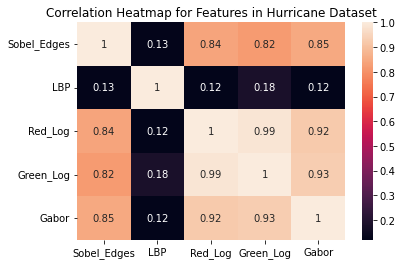

In [35]:
# Correlation heatmap for all features

features_only = hurricane_features.drop(columns = ["Label"])
heatmap = sns.heatmap(features_only.corr(), annot = True)
heatmap.set_title("Correlation Heatmap for Features in Hurricane Dataset")

hurricane_features.describe()

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

Use the same models used above by Marei and Sophia to compare performance, then see if it is possible to improve the network architecture for the CNN, or if we need to prepare our data differently for this dataset

In [36]:
X = hurricane_features.drop('Label', axis=1)
y = hurricane_features['Label']

# Scaling and Normalizing the data so that all feature data is between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.176723,0.615585,0.598100,0.623483,0.196219
std,0.103282,0.110527,0.120525,0.116816,0.116941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.101942,0.534177,0.519885,0.549484,0.117321
50%,0.156854,0.616156,0.594815,0.620358,0.166666
75%,0.230465,0.705557,0.677968,0.697992,0.242115
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

columns_list = hurricane_features.columns.tolist()
correlation_df = calculate_correlations(hurricane_features[columns_list])

model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

print(y_train.shape)

train_ce = cross_entropy(y_train_pred, y_train, class_weights)
test_ce = cross_entropy(y_valid_pred, y_valid, class_weights)

train_accuracy = accuracy_score(y_train_pred, y_train)
valid_accuracy = accuracy_score(y_valid_pred, y_valid)

print(f"Training CE: {train_ce:.2f}")
print(f"Validation CE: {test_ce:.2f}")

             Correlation with Label
LBP                        0.211722
Sobel_Edges               -0.023570
Red_Log                   -0.139005
Green_Log                 -0.159259
Gabor                     -0.167817
(4940,)


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: operands could not be broadcast together with shapes (4940,) (4940,4) 

When running the above model, I got an error saying that convergence failed and the total number of iterations was reached. This means that, from iteration to iteration, our error is greater than some built-in tolerance. While the score we receoved was good, I am doubtful that the model is truly converging onto some prediction criteria.

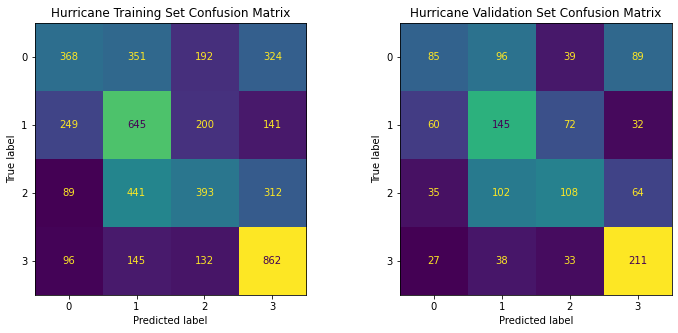

In [38]:
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=[0, 1, 2 ,3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")

plt.show()

From these confusion matrices, we see that we are classifying images as label 1 even when the image is not label 1

In [78]:
class_weights

array([1.05957811, 0.53241979, 1.80553756, 1.60215517])

### Hurricane Logistic with Gradient Descent and PCA

In [39]:
ohe_hurricane = pd.read_csv("/Users/sophia01px2019/Downloads/Data200-S-Computer-Vision-f1_and_logreg/hurricane_unbal_ohe.csv")
ohe_hurricane = ohe_hurricane.drop(columns = "Label")

def compute_class_weights(df, label_columns):

    y = df[label_columns].to_numpy()
    class_counts = y.sum(axis=0)
    total_samples = y.shape[0]
    num_classes = y.shape[1]
    
    # Compute weights inversely proportional to class frequency
    class_weights = total_samples / (num_classes * class_counts)
    return class_weights

label_columns = ['Label_0', 'Label_1', 'Label_2', 'Label_3']
class_weights = compute_class_weights(ohe_hurricane, label_columns)

print("Class Weights:", class_weights)

columns = ohe_hurricane.columns
columns

X = ohe_hurricane.drop(columns =['Label_0','Label_1', 'Label_2', 'Label_3'])
y = ohe_hurricane[['Label_0','Label_1', 'Label_2', 'Label_3']]

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

X_train = X_train.to_numpy()  # Converts pandas DataFrame to numpy array
y_train = y_train.to_numpy()  # Converts pandas DataFrame/Series to numpy array

Class Weights: [1.05957811 0.53241979 1.80553756 1.60215517]


In [40]:
# function definitions and imports for this section
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


# functions 

def calculate_correlations(data, target='Label'):
    correlations = {}
    
    if isinstance(target, list):  # If target is one-hot encoded
        data['Combined_Target'] = data[target].idxmax(axis=1)  # Combine to single target column
        target = 'Combined_Target'
    
    for column in data.columns:
        if column != target and pd.api.types.is_numeric_dtype(data[column]):
            correlation = data[[column, target]].corr().iloc[0, 1]
            correlations[column] = correlation

    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Label'])
    print(correlation_df.sort_values(by='Correlation with Label', ascending=False))
    return correlation_df


def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    """
    return np.sqrt(mean_squared_error(actual, predicted)) 

def cross_entropy(y_true, y_pred, class_weights):
    weights_matrix = np.array([class_weights] * y_true.shape[0])  # Expand weights for each sample
    weighted_y_true = y_true * weights_matrix
    loss = -np.sum(weighted_y_true * np.log(y_pred)) / y_true.shape[0]
    return loss


In [41]:
column_counts = ohe_hurricane.sum(axis=0)
print("Counts of 1.0 in each column:")
print(column_counts)

Counts of 1.0 in each column:
Sobel_Edges     10127.235320
LBP            186768.688638
Red_Log         81355.302782
Green_Log       84431.665485
Gabor           76045.327981
Label_0          2631.000000
Label_1          5236.000000
Label_2          1544.000000
Label_3          1740.000000
dtype: float64


In [42]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent_logistic(X, y, num_classes, class_weights, learning_rate=1, reg=0.001, iterations=100000):
    m, n = X.shape  
    weights = np.zeros((n, num_classes)) 
    bias = np.zeros(num_classes)       

    # Compute dynamic learning rates for each class based on class weights
    learning_rates = learning_rate * class_weights  

    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias 
        y_pred = softmax(linear_model)           

        # Apply class weights explicitly
        weights_matrix = np.tile(class_weights, (m, 1))  
        weighted_residuals = (y_pred - y) * weights_matrix  
        dw = (1 / m) * np.dot(X.T, weighted_residuals) + (reg / m) * weights  
        db = (1 / m) * np.sum(weighted_residuals, axis=0)                     

        for c in range(num_classes):
            weights[:, c] -= learning_rates[c] * dw[:, c]
            bias[c] -= learning_rates[c] * db[c]

        # Debug
        if i % 1000 == 0:
            print(f"Iteration {i}: Weights norm: {np.linalg.norm(weights):.4f}, Bias: {bias}")

    return weights, bias

def gradient_descent_logistic_focal(X, y, num_classes, class_weights, learning_rate=1, reg=0.001, iterations=10000, alpha=0.25, gamma=2):
    m, n = X.shape 
    weights = np.zeros((n, num_classes)) 
    bias = np.zeros(num_classes)         

    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias  
        y_pred = softmax(linear_model)         

        pt = np.sum(y_pred * y, axis=1, keepdims=True)  
        focal_factor = (1 - pt) ** gamma  # Focal factor: amplifies harder examples (m, 1)

        class_weight_matrix = np.dot(y, np.diag(class_weights))  
        weighted_focal = focal_factor * class_weight_matrix  # Shape: (m, num_classes)
        residuals = (y_pred - y) * weighted_focal 

        # Compute gradients
        dw = (1 / m) * np.dot(X.T, residuals) + (reg / m) * weights 
        db = (1 / m) * np.sum(residuals, axis=0)                   
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Debug
        if i % 1000 == 0:
            print(f"Iteration {i}: Weights norm: {np.linalg.norm(weights):.4f}, Bias: {bias}")
            print(f"Iteration {i}: Focal factor mean: {focal_factor.mean():.4f}")

    return weights, bias


def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# PCA for Dimensionality Reduction
def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca


def predict(X, weights, bias):
    # print("Bias Shape:" , bias.shape) # Debugging
    linear_model = np.dot(X, weights) + bias
    y_pred = softmax(linear_model)
    return np.argmax(y_pred, axis=1)

def to_one_hot(y_pred_ht, num_classes):
    y_pred_ht = np.array(y_pred_ht).astype(int)  # Ensure integers
    return np.eye(num_classes)[y_pred_ht]


In [43]:
# more function definitions to expand this implementation for 4 classes 
# apply k-fold cross validation
def generate_test_preds(test_set, weights, bias, pca_obj):
    '''
    For use with the pca / kfold function when a test_Set is provided
    '''
    test_scales = scaler.fit_transform(test_set)
    test_features = pca_obj.transform(test_scales)
    test_predictions = predict(test_features, weights, bias)
    output_path = "gradient_logistic_w_3pca_kfold_images_hurricane_predictions.csv"
    pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

def handle_test_set(test_set, weights, bias, pca_obj):
    if test_set is not None and not test_set.empty:
        generate_test_preds(test_set, weights, bias, pca_obj)

def apply_k_fold(X, y, k, num_classes, class_weights, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Use a random state for reproducibility
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train using gradient descent with class weights
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, class_weights, learning_rate, reg, iterations)

        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_valid_pred_ohe = to_one_hot(y_valid_pred, num_classes)

        score = accuracy_score(y_val, y_valid_pred_ohe)
        scores.append(score)

        handle_test_set(test_set, weights, bias, pca_hur)

    avg_score = np.mean(scores)
    return avg_score


# try to use a one vs rest classifier system to deal with the different classes
def train_one_vs_rest(X, y, num_classes, class_weights, learning_rate=1, reg=0.001, iterations=1000):
    weights_list = []
    bias_list = []

    for i in range(num_classes):
        # Create binary labels for the current class
        y_binary = y[:, i]  # Focus on the current class
        y_binary = np.vstack([1 - y_binary, y_binary]).T  # Convert to two columns (not-current-class, current-class)

        # Pass class weights for the current class
        binary_weights = np.array([class_weights[i], class_weights[i]])

        # Train logistic regression for the current class
        print(f"Training class {i} with binary labels")
        weights, bias = gradient_descent_logistic(X, y_binary, 2, binary_weights, learning_rate, reg, iterations)

        weights_list.append(weights)
        bias_list.append(bias)

    return weights_list, bias_list


def predict_one_vs_rest(X, weights_list, bias_list):
    probas = []
    for weights, bias in zip(weights_list, bias_list):
        linear_model = np.dot(X, weights) + bias
        probas.append(softmax(linear_model))  

    probas = np.array(probas) # Convert the list to a NumPy array
    # Debugging: Check the shape of probas
    # print("Shape of probas no transpose:", probas.shape)  # Should be (num_classes, num_samples)

    predictions = np.argmax(probas, axis=2)
    print("unique predictions", len(np.unique(predictions)))
    print("shape", predictions.shape)
    
    return predictions.T


In [44]:
learning = [0.01, 0.05, 0.1, 0.2, 1]
regs = [0.001, 0.01, 0.1, 1, 10]

top_accuracy = 0
params = {}

num_classes = 4

# Looping over hyperparameters
for rates in learning:
    for reg in regs:
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, class_weights, rates, reg)
            
        y_pred = predict(X_valid, weights, bias)
        y_pred_ht = to_one_hot(y_pred, num_classes)
            
        accuracy = accuracy_score(y_valid, y_pred_ht)
                
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            params = {'learning_rate': rates, 'regularization': reg}

print(f"Tuned Parameters: {params}")
print(f"Accuracy: {top_accuracy:.4f}")

Iteration 0: Weights norm: 0.0046, Bias: [-0.00015733  0.00062224 -0.0036364  -0.00241151]
Iteration 1000: Weights norm: 0.8216, Bias: [-0.19203171  0.13118069 -0.5151811  -0.34316844]
Iteration 2000: Weights norm: 1.1484, Bias: [-0.19688112  0.13361765 -0.58177158 -0.3017148 ]
Iteration 3000: Weights norm: 1.5129, Bias: [-0.19823266  0.13538132 -0.63895538 -0.26956861]
Iteration 4000: Weights norm: 1.8768, Bias: [-0.1998125   0.13765384 -0.68917947 -0.2469883 ]
Iteration 5000: Weights norm: 2.2280, Bias: [-0.20169374  0.1403778  -0.73329777 -0.23261452]
Iteration 6000: Weights norm: 2.5632, Bias: [-0.20389453  0.14349293 -0.77206069 -0.22526904]


KeyboardInterrupt: 

In [103]:
#Performing PCA on training and validation set 

if X_train.shape[1] > 4:  
    X_train_pca, X_valid_pca, pca_ratio, pca_hur = apply_pca(X_train, X_valid, n_components=3)


Explained variance by PCA components: [0.7420467  0.20232943 0.03802973]


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


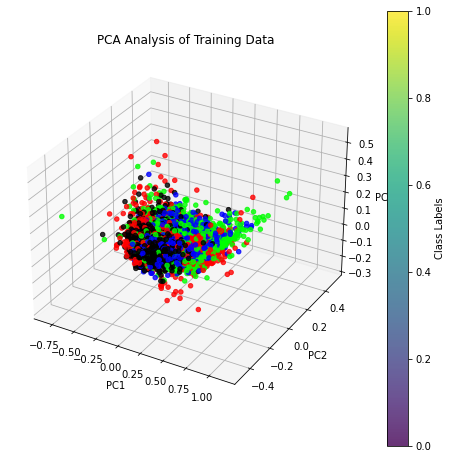

In [65]:
import matplotlib.pyplot as plt

def visualize_pca(X_pca, y, title="PCA Visualization"):
    plt.figure(figsize=(8, 8))

    if X_pca.shape[1] >= 3:
        # 3D visualization
        ax = plt.subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.8)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    else:
        # 2D visualization
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    plt.title(title)
    plt.colorbar(scatter, label="Class Labels")
    plt.grid(True)
    plt.show()

if X_train_pca.shape[1] >= 2:
    visualize_pca(X_train_pca, y_train, title="PCA Analysis of Training Data")

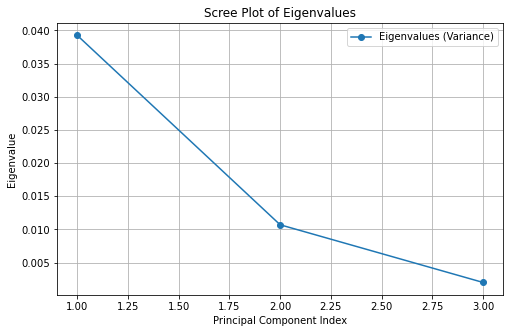

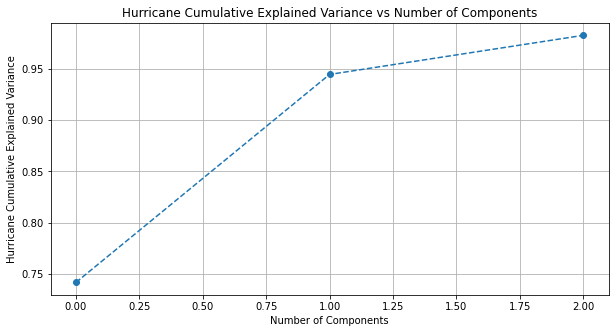

Number of components for 95% variance: 1


In [66]:
#Plotting the cumulative variance
eigenvalues = pca_hur.explained_variance_

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues (Variance)')
plt.title("Scree Plot of Eigenvalues")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.legend()
plt.show()

#Calculating cumulative variance 
cumulative_explained_variance = np.cumsum(pca_ratio)

# Plot cumulative explained variance to see effect of each feature on variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Hurricane Cumulative Explained Variance')
plt.title('Hurricane Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 95) + 1
print(f"Number of components for 95% variance: {n_components}")

The scree plot also suggest we may be able to just keep 3 of the PCA components. We may not need all of them

In [45]:
def cross_entropy(y_true, y_pred, class_weights):
    """
    Computes the weighted cross-entropy loss.
    Args:
        y_true (numpy array): One-hot encoded true labels (shape: [n_samples, n_classes]).
        y_pred (numpy array): Predicted probabilities (shape: [n_samples, n_classes]).
        class_weights (numpy array): Class weights (shape: [n_classes]).
    Returns:
        loss (float): Weighted cross-entropy loss.
    """
    # Ensure inputs are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Apply class weights column-wise
    weighted_y_true = y_true * class_weights
    
    # Compute the weighted cross-entropy loss
    loss = -np.sum(weighted_y_true * np.log(y_pred + 1e-12)) / y_true.shape[0]  # Add small epsilon to avoid log(0)
    return loss


Iteration 0: Weights norm: 0.4615, Bias: [-0.01573298  0.06222375 -0.36363969 -0.24115058]
Iteration 1000: Weights norm: 12.6991, Bias: [-0.82311339  0.54175251 -1.16195858 -2.1088532 ]
Iteration 2000: Weights norm: 16.2594, Bias: [-1.02852301  0.64086333 -1.23713309 -2.47749577]
Iteration 3000: Weights norm: 18.5340, Bias: [-0.96403515  0.63491497 -1.33660193 -2.49275199]
Iteration 4000: Weights norm: 20.2565, Bias: [-0.835401    0.60993148 -1.44687618 -2.47379301]
Iteration 5000: Weights norm: 21.6563, Bias: [-0.70667635  0.5859107  -1.54873958 -2.47038125]
Iteration 6000: Weights norm: 22.8366, Bias: [-0.59526675  0.56690826 -1.63441047 -2.48557348]
Iteration 7000: Weights norm: 23.8561, Bias: [-0.50394925  0.55299451 -1.70270945 -2.51458615]
Iteration 8000: Weights norm: 24.7533, Bias: [-0.43107008  0.54335126 -1.75524238 -2.55252711]
Iteration 9000: Weights norm: 25.5550, Bias: [-0.37386282  0.53708658 -1.79449002 -2.59569108]
Training CE: 16.29
Training Accuracy score: 0.54
Valid

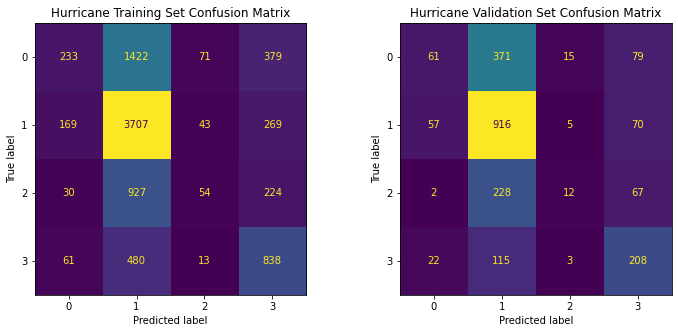

In [50]:
tuned_learning_rate = 1
tuned_regularization = 0.001

weights, bias = gradient_descent_logistic(
    X_train, 
    y_train, 
    num_classes, 
    class_weights = class_weights, 
    learning_rate=tuned_learning_rate, 
    reg=tuned_regularization, 
    iterations=10000,
)
y_train_pred = predict(X_train, weights, bias) 
y_train_pred_ohe = to_one_hot(y_train_pred, num_classes)

y_valid_pred = predict(X_valid, weights, bias) 
y_valid_pred_ohe = to_one_hot(y_valid_pred, num_classes)

train_ce = cross_entropy(y_train, y_train_pred_ohe, class_weights)
valid_ce = cross_entropy(y_valid, y_valid_pred_ohe, class_weights)

train_accuracy = accuracy_score(y_train, y_train_pred_ohe)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_ohe)
print(f"Training CE: {train_ce:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(f"Validation CE: {valid_ce:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")

y_train_labels = np.argmax(y_train_pred_ohe, axis=1) 
y_valid_labels = np.argmax(y_valid_pred_ohe, axis=1) 
y_train_linear = np.argmax(y_train, axis=1)
y_valid_linear = np.argmax(y_valid, axis=1)

# Save the predictions as a single-column CSV
output_path = "hurricane_nofocal_predictions.csv"
pd.DataFrame(y_valid_pred, columns=["pred"]).to_csv(output_path, index=False, header=True)

print(f"Predictions saved to {output_path}")

train_cm = confusion_matrix(y_train_linear, y_train_labels)
valid_cm = confusion_matrix(y_valid_linear, y_valid_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

Iteration 0: Weights norm: 0.2193, Bias: [0.10548823 0.10545806 0.10546113 0.10547821]
Iteration 0: Focal factor mean: 0.5625
Iteration 1000: Weights norm: 196.9106, Bias: [95.20504227 95.44339808 94.87729071 95.62890226]
Iteration 1000: Focal factor mean: 0.5024
Iteration 2000: Weights norm: 381.1755, Bias: [184.63328574 185.15674894 184.35360417 184.98319884]
Iteration 2000: Focal factor mean: 0.4888
Iteration 3000: Weights norm: 562.1404, Bias: [272.6768888  273.31071741 272.39853283 272.85663524]
Iteration 3000: Focal factor mean: 0.4818
Iteration 4000: Weights norm: 741.4323, Bias: [360.03126765 360.66914901 359.70629311 360.02189272]
Iteration 4000: Focal factor mean: 0.4774
Iteration 5000: Weights norm: 919.6590, Bias: [446.93938006 447.52069655 446.53668584 446.74477414]
Iteration 5000: Focal factor mean: 0.4742
Iteration 6000: Weights norm: 1097.1238, Bias: [533.51866243 534.00970756 533.01972261 533.14944722]
Iteration 6000: Focal factor mean: 0.4718
Iteration 7000: Weights n

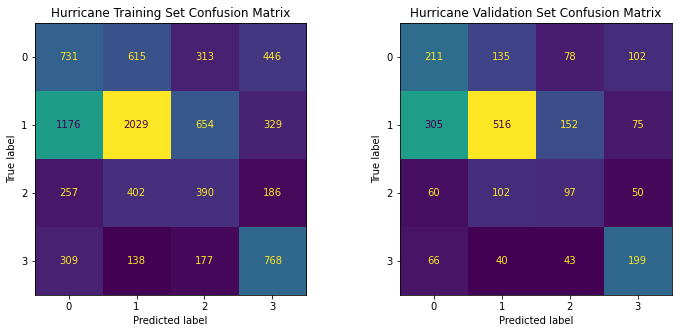

In [49]:
tuned_learning_rate = 1
tuned_regularization = 0.001

weights, bias = gradient_descent_logistic_focal(
    X_train, 
    y_train, 
    num_classes, 
    class_weights = class_weights, 
    learning_rate=tuned_learning_rate, 
    reg=tuned_regularization, 
    iterations=10000,
)
y_train_pred = predict(X_train, weights, bias) 
y_train_pred_ohe = to_one_hot(y_train_pred, num_classes)

y_valid_pred = predict(X_valid, weights, bias) 
y_valid_pred_ohe = to_one_hot(y_valid_pred, num_classes)

train_ce = cross_entropy(y_train, y_train_pred_ohe, class_weights)
valid_ce = cross_entropy(y_valid, y_valid_pred_ohe, class_weights)

train_accuracy = accuracy_score(y_train, y_train_pred_ohe)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_ohe)
print(f"Training CE: {train_ce:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(f"Validation CE: {valid_ce:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")

y_train_labels = np.argmax(y_train_pred_ohe, axis=1) 
y_valid_labels = np.argmax(y_valid_pred_ohe, axis=1) 
y_train_linear = np.argmax(y_train, axis=1)
y_valid_linear = np.argmax(y_valid, axis=1)

# Save the predictions as a single-column CSV
output_path = "hurricane_focal_predictions.csv"
pd.DataFrame(y_valid_pred, columns=["pred"]).to_csv(output_path, index=False, header=True)

print(f"Predictions saved to {output_path}")

train_cm = confusion_matrix(y_train_linear, y_train_labels)
valid_cm = confusion_matrix(y_valid_linear, y_valid_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

In [112]:
mean_probs = np.mean(y_pred, axis=0)
print("Mean predicted probabilities for each class:", mean_probs)

Mean predicted probabilities for each class: 1.2779022859704168


In [74]:
average_kfold_accuracy = apply_k_fold(X_train_pca, y_train, num_classes=4, k=5, test_set=None)
print(average_kfold_accuracy)

TypeError: apply_k_fold() missing 1 required positional argument: 'class_weights'

In [33]:
def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    """
    Perform k-fold cross-validation for logistic regression with metrics computation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}  # Initialize storage
    fold_num = 1 

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, class_weights, learning_rate, reg, iterations)

        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_val_labels = np.argmax(y_val, axis=1)  
        
        # Handle 1D or 2D predictions
        if len(y_valid_pred.shape) == 1:
            y_pred_labels = y_valid_pred  
        else:
            y_pred_labels = np.argmax(y_valid_pred, axis=1)  # Convert probabilities to class indices

        # Compute and append metrics
        accuracy = accuracy_score(y_val_labels, y_pred_labels)
        precision, recall, f1 = calculate_f1_scores(y_val_labels, y_pred_labels, average='macro')
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        
        print(f"\nMetrics for Fold {fold_num}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        fold_num += 1

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_hur)

    avg_results = {metric: np.mean(values) for metric, values in metrics.items()}

    print("\nCross-Validation Results (Averages):")
    for metric, value in avg_results.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return avg_results


In [34]:
# Running k-fold cross-validation with metrics computation
results = apply_k_fold(X_train_pca, y_train, k=5, num_classes=4, learning_rate=0.1, reg=0.01)

print("Final Averaged Metrics:")
for metric, value in results.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Precision (macro): 0.4103
Recall (macro): 0.3994
F1 Score (macro): 0.3360

Metrics for Fold 1:
  Accuracy: 0.3947
  Precision: 0.4103
  Recall: 0.3994
  F1 Score: 0.3360
Precision (macro): 0.3613
Recall (macro): 0.3837
F1 Score (macro): 0.3353

Metrics for Fold 2:
  Accuracy: 0.3836
  Precision: 0.3613
  Recall: 0.3837
  F1 Score: 0.3353
Precision (macro): 0.4162
Recall (macro): 0.4019
F1 Score (macro): 0.3670

Metrics for Fold 3:
  Accuracy: 0.4049
  Precision: 0.4162
  Recall: 0.4019
  F1 Score: 0.3670
Precision (macro): 0.3689
Recall (macro): 0.3908
F1 Score (macro): 0.3528

Metrics for Fold 4:
  Accuracy: 0.3856
  Precision: 0.3689
  Recall: 0.3908
  F1 Score: 0.3528
Precision (macro): 0.4087
Recall (macro): 0.4069
F1 Score (macro): 0.3658

Metrics for Fold 5:
  Accuracy: 0.4069
  Precision: 0.4087
  Recall: 0.4069
  F1 Score: 0.3658

Cross-Validation Results (Averages):
Accuracy: 0.3951
Precision: 0.3931
Recall: 0.3965
F1: 0.3514
Final Averaged Metrics:
Accuracy: 0.3951
Precision:

In [18]:
weights_list, bias_list = train_one_vs_rest(X_train_pca, y_train, num_classes=2)

# Make predictions
y_train_pred = predict_one_vs_rest(X_train_pca, weights_list, bias_list)
y_valid_pred = predict_one_vs_rest(X_valid_pca, weights_list, bias_list)


Training class 0 with binary labels
Training class 1 with binary labels
unique predictions 2
shape (2, 4940)
unique predictions 2
shape (2, 1236)


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_f1_scores(y_true, y_pred, average='macro'):
    """
    Calculate precision, recall, and F1 scores for multi-class classification.

    Args:
    - y_true: Ground truth labels (1D array).
    - y_pred: Predicted labels (1D array).
    - average: Averaging method ('macro', 'weighted', 'micro', or None).

    Returns:
    - precision: Precision score.
    - recall: Recall score.
    - f1: F1 score.
    """
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    
    print(f"Precision ({average}): {precision:.4f}")
    print(f"Recall ({average}): {recall:.4f}")
    print(f"F1 Score ({average}): {f1:.4f}")
    
    return precision, recall, f1


In [20]:
# Convert predictions and true labels to single-dimensional arrays
y_train_labels = np.argmax(y_train_pred, axis=1)
y_valid_labels = np.argmax(y_valid_pred, axis=1)
y_train_linear = np.argmax(y_train, axis=1)
y_valid_linear = np.argmax(y_valid, axis=1)

# Calculate F1 scores for training and validation sets
train_precision, train_recall, train_f1 = calculate_f1_scores(y_train_linear, y_train_labels, average='macro')
valid_precision, valid_recall, valid_f1 = calculate_f1_scores(y_valid_linear, y_valid_labels, average='macro')

print(f"Training F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {valid_f1:.4f}")

def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, class_weights, learning_rate, reg, iterations)
        
        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        y_valid_labels = np.argmax(y_valid_pred, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)

        # Accuracy Score
        accuracy = accuracy_score(y_val_labels, y_valid_labels)
        accuracy_scores.append(accuracy)

        # F1 Score
        _, _, f1 = calculate_f1_scores(y_val_labels, y_valid_labels, average='macro')
        f1_scores.append(f1)

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_hur)

    avg_accuracy = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_accuracy, avg_f1


Precision (macro): 0.0625
Recall (macro): 0.2500
F1 Score (macro): 0.1000
Precision (macro): 0.0623
Recall (macro): 0.2492
F1 Score (macro): 0.0997
Training F1 Score: 0.1000
Validation F1 Score: 0.0997


/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sophia01px2019/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


unique predicted classes: [0]
Class distribution in training labels: [1235 1235 1235 1235]
Training Accuracy score: 0.2500
Validation Accuracy score: 0.2492


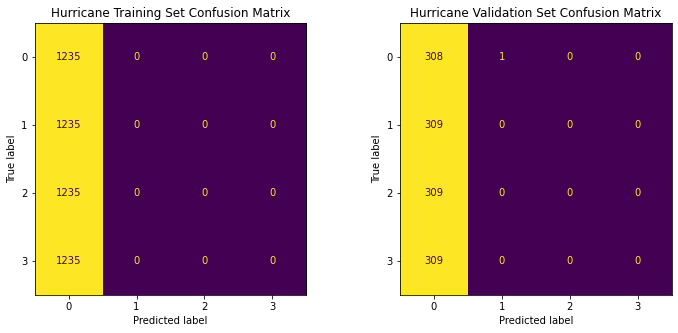

In [21]:
y_train_class = np.argmax(y_train, axis=1)  # shape will be (4940,)
y_valid_class = np.argmax(y_valid, axis=1)  # shape will be (1236,)
y_train_pred_class = np.argmax(y_train_pred, axis=1)  # shape will be (4940,)
y_valid_pred_class = np.argmax(y_valid_pred, axis=1)  # shape will be (1236,)

highest_class = np.argmax(y_train_pred, axis=1)
print("unique predicted classes:", np.unique(highest_class))
print("Class distribution in training labels:", np.bincount(y_train_class))

train_accuracy = np.mean(y_train_class == y_train_pred_class)
valid_accuracy = np.mean(y_valid_class == y_valid_pred_class)

# train_rmse = cross_entropy(y_train, y_train_pred)
# valid_rmse = cross_entropy(y_valid, y_valid_pred)

# print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training Accuracy score: {train_accuracy:.4f}")
# print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.4f}")

train_cm = confusion_matrix(y_train_class, y_train_pred_class)
valid_cm = confusion_matrix(y_valid_class, y_valid_pred_class)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

Well... this did not seem like it worked...

### CNN for Hurricane Dataset

In [ ]:
# necessary imports and definitions for this section
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from PIL import Image

#Used this tutorial for help: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

#Preprocess the images (resize) so they are all the same size (64 x 64)
def resize(images, size=(64, 64)):
    resized = []
    for image in images:
        image = Image.fromarray(image)
        image = image.resize(size)
        resized.append(np.array(image))
    return np.array(resized)

#Converting to Tensor (for use with PyTorch), and normalizing images
def toTensor(imageset):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    tensor = [transform(Image.fromarray(image)) for image in imageset]
    return torch.stack(tensor)

# Creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes=2): #takes in number of classes, default at 2 for fire/flood dataset
        super(ConvNeuralNet, self).__init__()
        #2 layers with a max pooling layer. 3 kernels for RGB data
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) 
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #another 2 layers with a max pooling layer
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # 2 more layers with another max pooling layer
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(10816, 128) # linear layer
        self.relu1 = nn.ReLU() #ReLU activation function
        self.fc2 = nn.Linear(128, num_classes) #linear layer that maps to the classes
    
    # Moving images through CNN    
    def forward(self, x): 
        out = self.conv_layer1(x) #first conv layer
        out = self.conv_layer2(out) #second conv layer
        out = self.max_pool1(out) #max pooling layer (dimensionality reduction)
        
        out = self.conv_layer3(out) #third conv layer
        out = self.conv_layer4(out) #fourth conv layer
        out = self.max_pool2(out) #max pooling layer (dimensionality reduction)
                
        out = out.reshape(out.size(0), -1) # flattens to 1D before feeding to linear layers
        
        out = self.fc1(out) #first linear layer
        out = self.relu1(out) #activation function
        out = self.fc2(out) #second connected layer
        return out



In [ ]:
# loading in the raw images 

disaster_list = ["hurricane-matthew"]

data = {}
split = "train"

with open('config.json') as config_file:
    config = json.load(config_file)
    # data_dir = "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"
    data_dir = "satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

# choose hurricane-matthew from our labels list 
disaster = disaster_list[0]

#separate the labels and the images for our EDA
hurricane_matthew_labels = data[disaster]["labels"]
hurricane_matthew_images = data[disaster]["images"]

In [ ]:
# data cleaning and formatting for the CNN
random.seed(42)

random_0_indeces = random.sample(list(np.where(hurricane_matthew_labels == 0)[0]), 1544)
random_1_indeces = random.sample(list(np.where(hurricane_matthew_labels == 1)[0]), 1544)
random_3_indeces = random.sample(list(np.where(hurricane_matthew_labels == 3)[0]), 1544)
random_2_indeces = random.sample(list(np.where(hurricane_matthew_labels == 2)[0]), 1544)

sum_indeces = random_0_indeces + random_1_indeces + random_3_indeces + random_2_indeces

hurricane_matthew_0_cnn = np.array(hurricane_matthew_labels[random_0_indeces])
hurricane_matthew_1_cnn = np.array(hurricane_matthew_labels[random_1_indeces])
hurricane_matthew_2_cnn = np.array(hurricane_matthew_labels[random_2_indeces])
hurricane_matthew_3_cnn = np.array(hurricane_matthew_labels[random_3_indeces])

hurricane_matthew_labels_eq = np.concatenate([
    hurricane_matthew_0_cnn,
    hurricane_matthew_1_cnn,
    hurricane_matthew_2_cnn,
    hurricane_matthew_3_cnn
])

filtered_images = [hurricane_matthew_images[index] for index in indeces]

hurricane_matthew_resized = resize(filtered_images)

filtered_images = [hurricane_matthew_images[index] for index in hurricane_matthew_labels_eq]

hurricane_matthew_resized = resize(filtered_images)

# convert all images and labels to tensors
hurricane_images_tensor = toTensor(hurricane_matthew_resized)
hurricane_labels_tensor = torch.tensor(hurricane_matthew_labels_eq, dtype = torch.long)

In [ ]:
# loader objects for PyTorch
#Split into validation and training sets
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(hurricane_images_tensor, hurricane_labels_tensor, test_size=0.2, random_state=42)

#Create tensor datasets to load into the loader object
train_dataset = TensorDataset(X_train_CNN, y_train_CNN)
valid_dataset = TensorDataset(X_valid_CNN, y_valid_CNN)

#Create loader objects (preserves memory by only loading the images batch by batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# hyperparameters 
num_classes = 4 #number of classes in our dataset
learning_rate = 0.001 #initializing initial learning rate

#setting up model using our custom class
cnn_model = ConvNeuralNet(num_classes)

# using cross entropy for the loss function
loss_func = nn.CrossEntropyLoss()

# set optimizer for CNN (stochastic gradient descent)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#set total length of training data
total_step = len(train_loader)

In [ ]:
#takes ~20 mins to run!
num_epochs = 20 #number of times to run the CNN

# set device to run 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Counters for visualization of training loss and accuracy
train_loss = []
train_accuracy = []


for epoch in range(num_epochs):
    #training mode
    cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # user loader object to load the data
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward through the CNN
        outputs = cnn_model(images) 
        loss = loss_func(outputs, labels) #calculate loss
        
        # Backpropagation, optimize parameters
        optimizer.zero_grad() #use SGD to optimize weights
        loss.backward() #check new gradient with loss function
        optimizer.step() #update weights

        running_loss += loss.item() #add all loss over this loop to running_loss

        _, predicted_train = torch.max(outputs.data, 1) # get current prediction for this epoch
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item() #compare prediction with label

    
    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader) #gives the average loss over the epoch
    train_loss.append(avg_loss)
    t_accuracy = 100 * correct_train / total_train
    train_accuracy.append(t_accuracy)
    
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}%'.format(epoch+1, num_epochs, avg_loss, t_accuracy))


In [ ]:
#Running training set through the optimized CNN to calculate accuracy

#do not need gradient optimization for evaluation 
with torch.no_grad():
    cnn_model.eval() #model in evaluation mode 
    correct = 0 #set initial correct prediction counter to 0 
    total = 0 #total predictions
    for images, labels in train_loader: #loop through images in the loader
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the train images: {} %'.format(100 * correct / total))

In [ ]:
#Running validation set through the optimized CNN to calculate accuracy

cnn_model.eval() #model in evaluation mode


#collecting metrics from validation evaluation run as well
valid_loss = 0.0
valid_accuracy = []
correct_valid = 0
total_valid = 0

#do not need gradient optimization for validation set
with torch.no_grad(): 
    for images, labels in valid_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)

        #loss
        loss = loss_func(outputs, labels)
        valid_loss += loss.item()

        #accuracy
        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

avg_valid_loss = valid_loss / len(valid_loader)
valid_accuracy = 100 * correct_valid / total_valid
    
print(f'Validation Loss: {avg_valid_loss:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')

In [ ]:
#Visualization of training loss and accuracy

xplot = np.arange(20)

fig1, ax1 = plt.subplots(2, 1, sharex = True)
ax1[0].plot(xplot, train_accuracy)
ax1[0].set_ylabel('Accuracy [%]')
ax1[0].set_ylim(90, 101)
ax1[1].plot(xplot, train_loss)
ax1[1].set_ylabel('Loss')
ax1[1].set_ylim(0, 0.1)

ax1[1].set_xlabel('Epochs')
fig1.suptitle('Training Loss and Accuracy')


plt.show()

## Performance Assessment

Use the model to generate predictions for the `test_images_hurricane-matthew.npz` images. This should be in a CSV file `test_images_hurricane-matthew_predictions.csv` consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row *i* should correspond to the *i*th image.

In [ ]:
test_im_hurricane_path = os.path.join(data_dir, "test_images_hurricane-matthew.npz")
test_im_hurricane = load_images(test_im_hurricane_path)

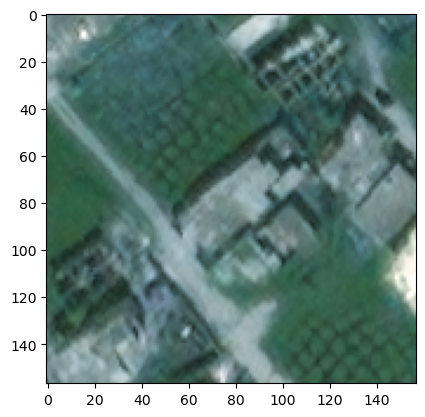

In [32]:
plt.imshow(test_im_hurricane[0]);

In [33]:
test_sobel_edges = img_to_sobel(test_im_hurricane)
test_lbp = img_to_LBP(test_im_hurricane)  
test_red, test_green, test_blue = image_to_RGB(test_im_hurricane)
test_red_log = np.log(np.array(test_red))
test_green_log = np.log(np.array(test_green))
test_blue_log = np.log(np.array(test_blue))  # not used, keeping for consistency
test_gabor = img_to_gabor(test_im_hurricane)

# Combine all features into df
test_features = pd.DataFrame({
    'Sobel_Edges': test_sobel_edges,
    "LBP": test_lbp,
    'Red_Log': test_red_log,
    'Green_Log': test_green_log,
    'Gabor': test_gabor
})

## Logistic

In [290]:
test_predictions = model.predict(test_features)
output_path = "logistic_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

## Gradient

In [123]:
def generate_test_preds(test_set, weights, bias, pca_obj, output_path="logistic_test_images_hurricane_predictions.csv"):
    """
    Generate test set predictions and save them as a single-column CSV file.
    Args:
        test_set (pd.DataFrame or np.array): The test set features.
        weights (np.array): Model weights.
        bias (np.array): Model biases.
        pca_obj: PCA object to transform the test set.
        output_path (str): Path to save the predictions CSV file.
    """
    # Scale and transform the test set
    scaler = MinMaxScaler()
    test_scales = scaler.fit_transform(test_set)
    test_features = pca_obj.transform(test_scales)

    # Predict class labels
    test_predictions = predict(test_features, weights, bias)

    # Save predictions to CSV as a single column
    predictions_df = pd.DataFrame(test_predictions, columns=["Predicted_Label"])
    predictions_df.to_csv(output_path, index=False, header=False)
    print(f"Predictions saved to {output_path}")


In [124]:
generate_test_preds(
    test_set=X_test,            # Replace with your test set DataFrame
    weights=weights,            # Trained model weights
    bias=bias,                  # Trained model bias
    pca_obj=pca_hur,            # PCA object used during training
    output_path="hurricane_predictions.csv"  # Output file name
)

NameError: name 'X_test' is not defined

## CNN

In [48]:
# Define a loader for the test dataset
test_images = resize(test_im_hurricane)
test_features = toTensor(test_images)

test_dataset = TensorDataset(test_features)

test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

cnn_model.eval() #model in test mode

test_predictions = []

#do not need gradient optimization 
with torch.no_grad(): 
    for images in test_loader: 
        images = images[0].to(device)
        outputs = cnn_model(images)

        _, predicted = torch.max(outputs.data, 1)

        test_predictions.append(predicted.cpu().numpy())

output_path = "cnn_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to cnn_test_images_hurricane_predictions.csv
